# DINOv3 + U-Net for Pixel-Level Lake Segmentation

This notebook shows how to:
1. Use DINOv3 as a feature extractor (frozen backbone)
2. Add a U-Net decoder for pixel-level segmentation
3. Train on your manual lake masks
4. Get precise lake boundaries (not just patch-level predictions)

**Key difference from previous approach:**
- Previous: 224x224 patch → single prediction ("has lake")
- This: 224x224 patch → 224x224 mask (pixel-level "which pixels are lake")

## Step 1: Setup and Imports

In [1]:
# install the dino and satellite trained model
# 1. Install required packages
!pip install torch torchvision transformers accelerate


# Core ML packages
!pip install torch torchvision transformers accelerate

# Computer vision and image processing
!pip install opencv-python pillow scikit-image

# Scientific computing
!pip install numpy scipy scikit-learn

# Geospatial packages (for satellite imagery)
!pip install rasterio geopandas fiona shapely

# Visualization
!pip install matplotlib seaborn plotly

# U-Net specific packages
!pip install segmentation-models-pytorch  # Popular U-Net implementations
# OR
!pip install pytorch-lightning  # If using PyTorch Lightning for U-Net

# HuggingFace integration
!pip install datasets huggingface-hub

# Progress bars and utilities
!pip install tqdm

# For handling large arrays efficiently
!pip install h5py

# Optional: For advanced metrics
!pip install torchmetrics


In [ ]:
# 2. Login to HuggingFace (you'll need your token)
from huggingface_hub import login
login(token="HF-token")  # This will prompt for your HF token

# 3. Load the satellite-trained DINOv3 model
from transformers import AutoModel, AutoImageProcessor

# The satellite version (26GB - trained on 493M Maxar images)
model_name = "facebook/dinov3-vit7b16-pretrain-sat493m"


processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

print(f"✅ Loaded {model_name}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Loaded facebook/dinov3-vit7b16-pretrain-sat493m


In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import cv2  # Added for resizing


# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# DINOv3
from transformers import Dinov2Model, Dinov2Config
from huggingface_hub import login

# Login (you already have this)
login(token="HF-token")  # This will prompt for your HF token

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 2: Load Your Data

In [4]:

# mount drive
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted at /content/drive")


# image = '2021-09-04_fndwi_clip_sam.tif'
# image = '/content/drive/MyDrive/superlakes/2021-09-04_rgb_testclip_sam2.tif'
# image = '/content/drive/MyDrive/superlakes/2021-09-04_fcc_testclip.tif'
image_path = '/content/drive/MyDrive/superlakes/2021-09-04_fcc_testclip2.tif'
mask_path = '/content/drive/MyDrive/superlakes/lake_mask_testclip2.tif'

shp_file = '/content/drive/MyDrive/superlakes/vectors/clip_by_glacier.shp'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted at /content/drive


In [5]:
# Load your satellite image and mask
# image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_testclip2.tif"
# mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask_testclip2.tif"

with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (channels, height, width)
    image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)

with rasterio.open(mask_path) as src:
    mask = src.read(1)  # Read first band

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

# Convert to 0-255 range for neural networks
image_rgb = image[:,:,:3].astype(np.uint8)
mask_binary = (mask > 0).astype(np.float32)  # Binary mask for training

Image shape: (4673, 1362, 4)
Mask shape: (4673, 1362)


In [6]:
# # Step 2: Keep the Model the Same (224x224 output)

#   # The model stays exactly the same - it works with 224x224
#   model = DINOv3UNet().to(device)  # No changes needed!

#   # Loss and optimizer stay the same
#   criterion = nn.BCELoss()
#   optimizer = optim.Adam(model.decoder.parameters(), lr=0.001)

#   Step 3: Update Training Call

#   # Use the new dataloader
#   print("Starting training...")
#   train_model(model, small_dataloader, criterion, optimizer, num_epochs=5)  # Changed dataloader name
#   print("Training completed!")


## Step 3: Create Training Dataset

In [9]:
# NEW: Add shapefile constraint to patch sampling

import geopandas as gpd
from rasterio.features import geometry_mask
from shapely.geometry import Point
import os

def create_boundary_mask(image_path, shapefile_path):
    """
    Create a binary mask from shapefile that matches the image
    """
    print(f"Creating boundary mask from: {os.path.basename(shapefile_path)}")

    # Load shapefile
    gdf = gpd.read_file(shapefile_path)
    print(f"   Loaded {len(gdf)} polygon(s)")

    # Load image to get transform and shape
    with rasterio.open(image_path) as src:
        transform = src.transform
        shape = src.shape
        crs = src.crs

    print(f"   Image CRS: {crs}")
    print(f"   Shapefile CRS: {gdf.crs}")

    # Reproject shapefile to match image CRS if needed
    if gdf.crs != crs:
        print(f"   Reprojecting shapefile from {gdf.crs} to {crs}")
        gdf = gdf.to_crs(crs)

    # Create mask - True inside polygons, False outside
    mask = ~geometry_mask(gdf.geometry, transform=transform, invert=False, out_shape=shape)

    print(f"   Boundary mask created: {mask.sum():,} pixels inside boundary ({mask.sum()/mask.size*100:.1f}%)")

    return mask

class BoundaryConstrainedLakeDataset(Dataset):
    """
    Dataset that only samples patches INSIDE the shapefile boundary
    """
    def __init__(self, image, mask, boundary_mask, conceptual_patch_size=32, max_patches=500, lake_ratio=0.7):
        self.conceptual_size = conceptual_patch_size
        self.dinov3_size = 224

        self.patches = []
        self.mask_patches = []

        height, width = image.shape[:2]

        print(f"Creating {conceptual_patch_size}x{conceptual_patch_size} patches ONLY inside boundary...")

        # Find patches inside boundary
        lake_patches = []
        no_lake_patches = []
        boundary_patches_checked = 0

        for y in range(0, height-conceptual_patch_size, conceptual_patch_size//8):  # Dense sampling
            for x in range(0, width-conceptual_patch_size, conceptual_patch_size//8):
                if y + conceptual_patch_size <= height and x + conceptual_patch_size <= width:

                    # Check if patch center is inside boundary
                    center_y = y + conceptual_patch_size // 2
                    center_x = x + conceptual_patch_size // 2

                    if boundary_mask[center_y, center_x]:  # Inside boundary
                        boundary_patches_checked += 1

                        mask_patch = mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size]
                        lake_pixels = mask_patch.sum()
                        total_pixels = conceptual_patch_size * conceptual_patch_size
                        lake_percentage = lake_pixels / total_pixels

                        patch_info = {
                            'y': y, 'x': x,
                            'lake_percentage': lake_percentage
                        }

                        if lake_percentage > 0.01:  # At least 1% lake coverage
                            lake_patches.append(patch_info)
                        elif lake_percentage == 0:  # Pure background
                            no_lake_patches.append(patch_info)

        print(f"   Checked {boundary_patches_checked} patches inside boundary")
        print(f"   Found {len(lake_patches)} patches with lakes")
        print(f"   Found {len(no_lake_patches)} background patches")

        # Create balanced dataset
        n_lake_patches = min(len(lake_patches), int(max_patches * lake_ratio))
        n_background_patches = min(len(no_lake_patches), max_patches - n_lake_patches)

        print(f"   Selecting {n_lake_patches} lake patches")
        print(f"   Selecting {n_background_patches} background patches")

        # Sort lake patches by lake percentage
        lake_patches.sort(key=lambda x: x['lake_percentage'], reverse=True)

        # Add lake patches
        for i in range(n_lake_patches):
            patch_info = lake_patches[i]
            y, x = patch_info['y'], patch_info['x']

            img_patch = image[y:y+conceptual_patch_size, x:x+conceptual_patch_size]
            mask_patch = mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size]

            self.patches.append(img_patch)
            self.mask_patches.append(mask_patch)

        # Add background patches
        import random
        random.shuffle(no_lake_patches)
        for i in range(n_background_patches):
            patch_info = no_lake_patches[i]
            y, x = patch_info['y'], patch_info['x']

            img_patch = image[y:y+conceptual_patch_size, x:x+conceptual_patch_size]
            mask_patch = mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size]

            self.patches.append(img_patch)
            self.mask_patches.append(mask_patch)

        print(f"   Final dataset: {len(self.patches)} patches from inside boundary only")

        # Data transforms
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        image_patch = self.patches[idx]
        mask_patch = self.mask_patches[idx]

        # Resize to 224x224 for DINOv3
        image_224 = cv2.resize(image_patch, (self.dinov3_size, self.dinov3_size))
        mask_224 = cv2.resize(mask_patch.astype(np.float32), (self.dinov3_size, self.dinov3_size))

        # Transform
        image_tensor = self.transform(image_224)
        mask_tensor = torch.from_numpy(mask_224).float().unsqueeze(0)

        return image_tensor, mask_tensor

# Usage example:
# 1. Create boundary mask from your shapefile
shapefile_path = shp_file # UPDATE THIS PATH
image_path = image_path

# Create boundary mask
boundary_mask = create_boundary_mask(image_path, shapefile_path)

# 2. Create dataset that only samples inside boundary
boundary_dataset = BoundaryConstrainedLakeDataset(
    image_rgb, mask_binary, boundary_mask,
    conceptual_patch_size=16,  # Smaller patches
    max_patches=5000,           # More patches
    lake_ratio=0.7
)

boundary_dataloader = DataLoader(boundary_dataset, batch_size=4, shuffle=True)

print(f"✅ Created boundary-constrained dataset with {len(boundary_dataset)} patches")



Creating boundary mask from: clip_by_glacier.shp
   Loaded 1 polygon(s)
   Image CRS: EPSG:32645
   Shapefile CRS: EPSG:4326
   Reprojecting shapefile from EPSG:4326 to EPSG:32645
   Boundary mask created: 1,409,146 pixels inside boundary (22.1%)
Creating 16x16 patches ONLY inside boundary...
   Checked 351945 patches inside boundary
   Found 25941 patches with lakes
   Found 324689 background patches
   Selecting 3500 lake patches
   Selecting 1500 background patches
   Final dataset: 5000 patches from inside boundary only
✅ Created boundary-constrained dataset with 5000 patches


## Step 4: Define DINOv3 + U-Net Model

In [10]:
class DynamicUNetDecoder(nn.Module):
    """
    Dynamic U-Net decoder that adapts to any input spatial size and ensures 224x224 output
    """
    def __init__(self, feature_dim=768, num_classes=1, target_size=224):
        super(DynamicUNetDecoder, self).__init__()
        self.target_size = target_size

        # Adaptive upsampling layers
        self.conv1 = nn.Conv2d(feature_dim, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(f"Decoder input shape: {x.shape}")

        # Apply initial convolutions
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.final(x)

        print(f"Before final resize: {x.shape}")

        # Always resize to exact target size (224x224)
        x = nn.functional.interpolate(x, size=(self.target_size, self.target_size), mode='bilinear', align_corners=False)

        print(f"After final resize: {x.shape}")

        x = self.sigmoid(x)
        return x


class DINOv3UNet(nn.Module):
    """
    Complete model: DINOv3 backbone + Dynamic U-Net decoder for segmentation
    """
    def __init__(self):
        super(DINOv3UNet, self).__init__()

        # Load actual DINOv3 model
        from transformers import AutoModel
        self.dinov3 = AutoModel.from_pretrained("facebook/dinov3-vitb16-pretrain-lvd1689m")

        # Freeze DINOv3 parameters (use as feature extractor only)
        for param in self.dinov3.parameters():
            param.requires_grad = False

        # Dynamic U-Net decoder
        self.decoder = DynamicUNetDecoder(feature_dim=768, target_size=224)

        print("Model created: DINOv3 (frozen) + Dynamic U-Net decoder (trainable)")

    def forward(self, x):
        # Extract features with DINOv3
        with torch.no_grad():  # Don't compute gradients for DINOv3
            features = self.dinov3(x).last_hidden_state

            # Debug: print actual shape to understand DINOv3 output
            print(f"DINOv3 features shape: {features.shape}")

            # Remove CLS token
            patch_features = features[:, 1:]  # Remove first token (CLS)
            print(f"After removing CLS token: {patch_features.shape}")

            # Calculate actual spatial dimensions
            batch_size, num_patches, feature_dim = patch_features.shape

            # Try to find the correct spatial dimensions
            # For DINOv3, this might not be a perfect square
            possible_dims = []
            for h in range(1, num_patches + 1):
                if num_patches % h == 0:
                    w = num_patches // h
                    possible_dims.append((h, w))

            # Choose dimensions closest to square, or if no good square, pick reasonable ratio
            if possible_dims:
                h, w = min(possible_dims, key=lambda dims: abs(dims[0] - dims[1]))
            else:
                # Fallback: try to make it as square as possible
                h = int(num_patches**0.5)
                w = int(num_patches**0.5)

            print(f"Using spatial dimensions: {h}x{w} = {h*w} patches (target: {num_patches})")

            # If dimensions don't match exactly, pad or truncate
            if h * w != num_patches:
                print(f"Dimension mismatch! Adjusting...")
                # Pad with zeros if needed
                needed_patches = h * w
                if needed_patches > num_patches:
                    padding = torch.zeros(batch_size, needed_patches - num_patches, feature_dim, device=patch_features.device)
                    patch_features = torch.cat([patch_features, padding], dim=1)
                else:
                    patch_features = patch_features[:, :needed_patches]
                print(f"Adjusted to: {patch_features.shape}")

            # Reshape to 2D feature map
            feature_map = patch_features.reshape(batch_size, h, w, feature_dim)
            feature_map = feature_map.permute(0, 3, 1, 2)  # (batch, feature_dim, H, W)

            print(f"Final feature map shape: {feature_map.shape}")

        # Generate segmentation mask
        mask = self.decoder(feature_map)
        print(f"Final output mask shape: {mask.shape}")

        return mask

# Create model
model = DINOv3UNet().to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy for lake/no-lake
optimizer = optim.Adam(model.decoder.parameters(), lr=0.001)  # Only train decoder

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created: DINOv3 (frozen) + Dynamic U-Net decoder (trainable)
Model parameters: 5,088,257


=== CURRENT SETTINGS (64x64 patches, stride=16) ===


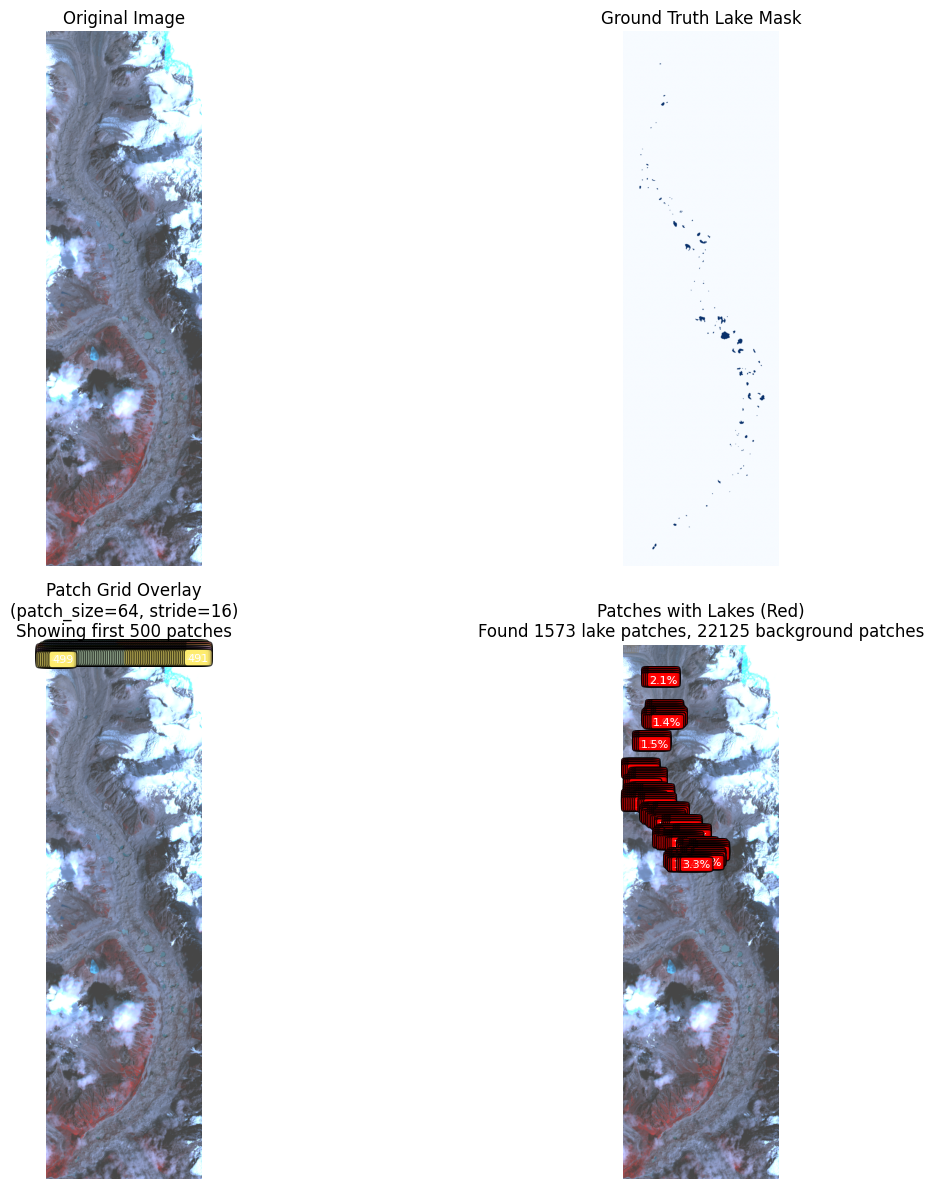

Patch Analysis:
  Patch size: 64x64 pixels
  Stride: 16 pixels
  Image size: 1362x4673 pixels
  Total possible patches: 23698
  Patches with lakes: 1573
  Background patches: 22125
  Lake coverage in patches: 1.0% to 82.0%

=== SMALLER PATCHES (32x32 patches, stride=8) ===


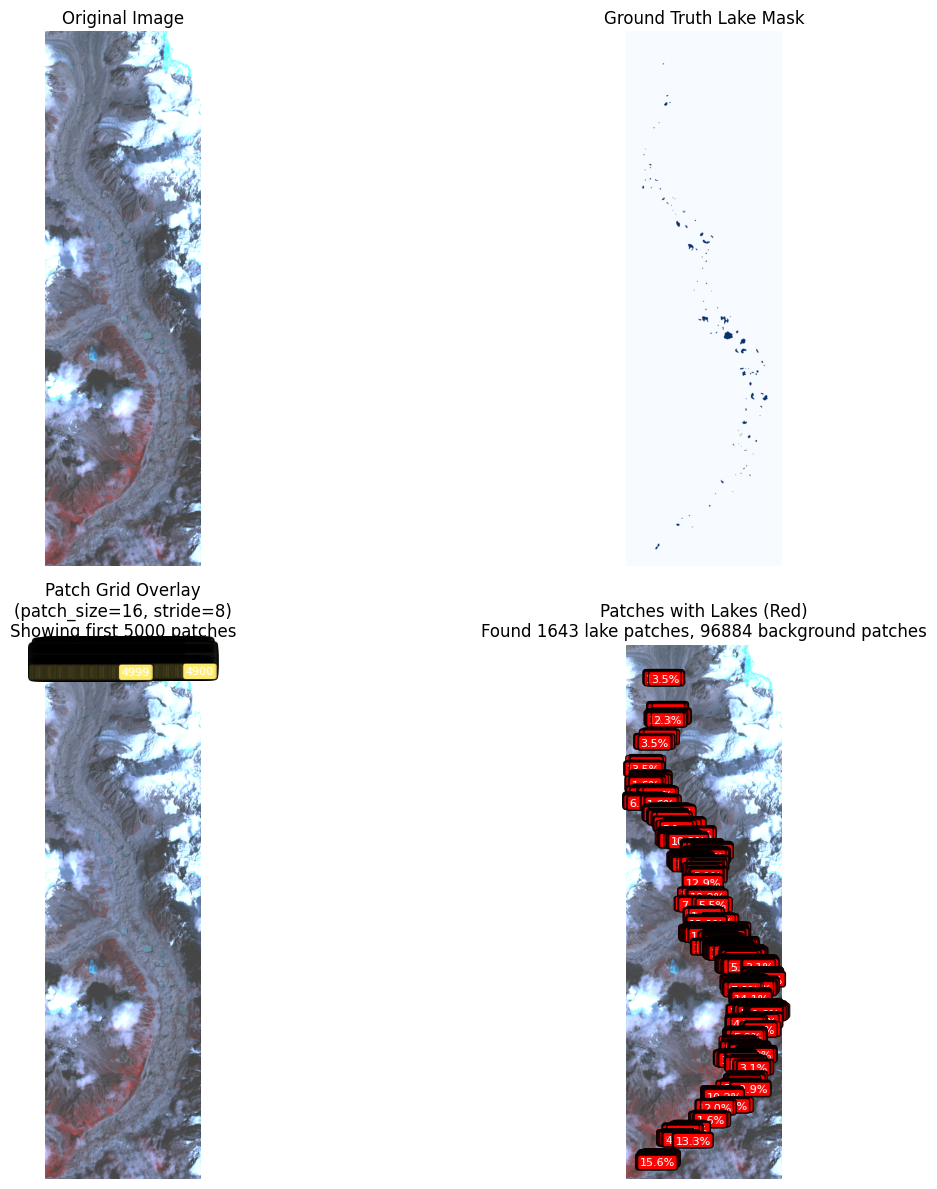

Patch Analysis:
  Patch size: 16x16 pixels
  Stride: 8 pixels
  Image size: 1362x4673 pixels
  Total possible patches: 98527
  Patches with lakes: 1643
  Background patches: 96884
  Lake coverage in patches: 1.2% to 100.0%

=== TINY PATCHES (16x16 patches, stride=4) ===


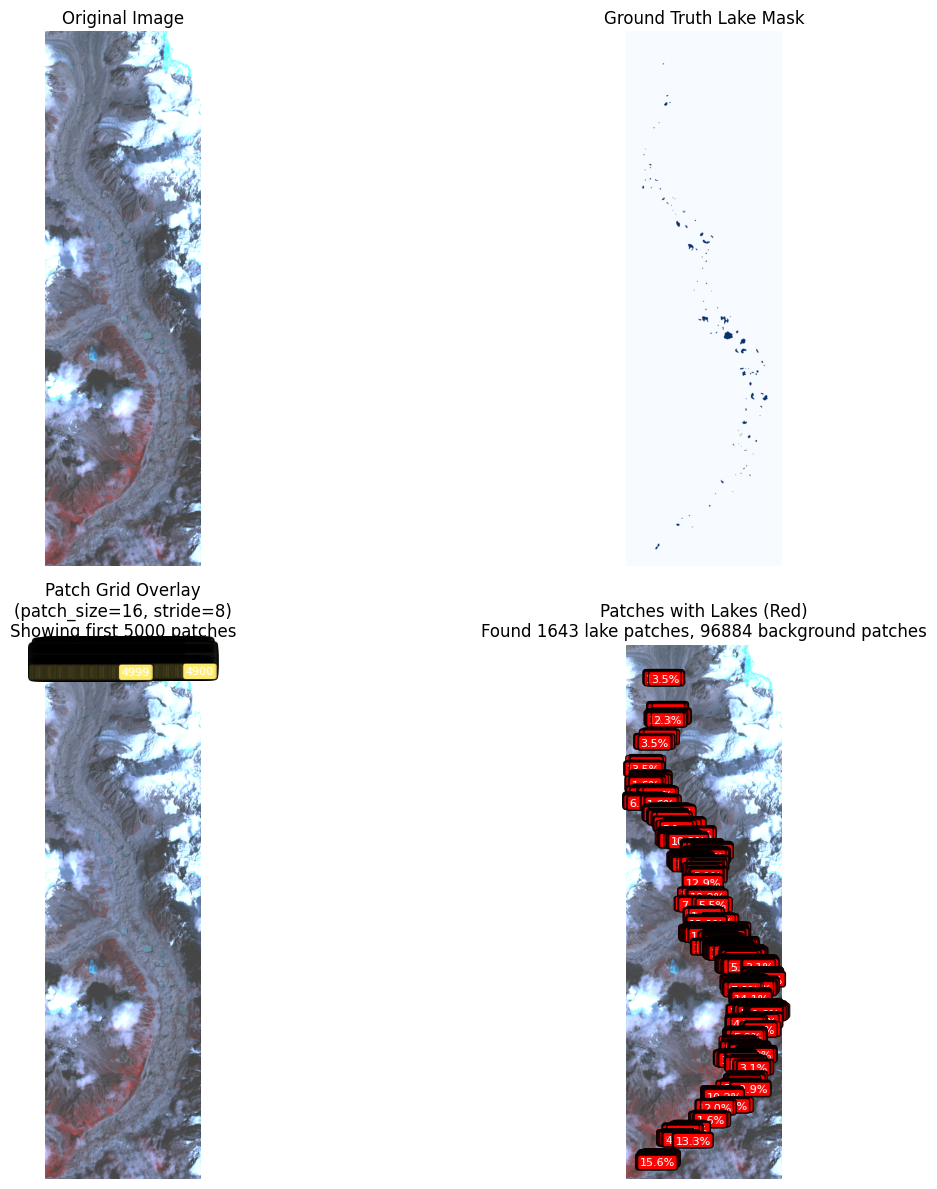

Patch Analysis:
  Patch size: 16x16 pixels
  Stride: 8 pixels
  Image size: 1362x4673 pixels
  Total possible patches: 98527
  Patches with lakes: 1643
  Background patches: 96884
  Lake coverage in patches: 1.2% to 100.0%


In [11]:
# NEW CELL: Visualize Patches to Understand the Problem
def visualize_patches_on_image(image, mask, patch_size=64, stride=32, max_patches_to_show=20):
    """
    Visualize what patches we're creating and where they are on the image
    """
    height, width = image.shape[:2]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # 2. Ground truth mask
    axes[0, 1].imshow(mask, cmap='Blues')
    axes[0, 1].set_title('Ground Truth Lake Mask')
    axes[0, 1].axis('off')

    # 3. Show patch grid overlay on image
    axes[1, 0].imshow(image)

    patch_count = 0
    colors = plt.cm.Set3(np.linspace(0, 1, max_patches_to_show))

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            if patch_count < max_patches_to_show:
                # Draw rectangle for each patch
                rect = plt.Rectangle((x, y), patch_size, patch_size,
                                    linewidth=2, edgecolor=colors[patch_count],
                                    facecolor='none')
                axes[1, 0].add_patch(rect)

                # Add patch number
                axes[1, 0].text(x + patch_size//2, y + patch_size//2,
                                str(patch_count), color='white',
                                fontsize=8, ha='center', va='center',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[patch_count], alpha=0.7))
                patch_count += 1
            else:
                break
        if patch_count >= max_patches_to_show:
            break

    axes[1, 0].set_title(f'Patch Grid Overlay\n(patch_size={patch_size}, stride={stride})\nShowing first {max_patches_to_show} patches')
    axes[1, 0].axis('off')

    # 4. Show which patches have lakes
    axes[1, 1].imshow(image)

    patch_count = 0
    lake_patches = []
    no_lake_patches = []

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            lake_percentage = mask_patch.sum() / (patch_size * patch_size)

            if lake_percentage > 0.01:  # Has lakes
                lake_patches.append((x, y, lake_percentage))
                if len(lake_patches) <= max_patches_to_show:
                    rect = plt.Rectangle((x, y), patch_size, patch_size,
                                        linewidth=3, edgecolor='red', facecolor='red', alpha=0.3)
                    axes[1, 1].add_patch(rect)
                    axes[1, 1].text(x + patch_size//2, y + patch_size//2,
                                    f'{lake_percentage:.1%}', color='white',
                                    fontsize=8, ha='center', va='center',
                                    bbox=dict(boxstyle="round,pad=0.2", facecolor='red', alpha=0.8))
            else:  # No lakes
                no_lake_patches.append((x, y))
                if len(no_lake_patches) <= 5:  # Show just a few background patches
                    rect = plt.Rectangle((x, y), patch_size, patch_size,
                                        linewidth=1, edgecolor='gray', facecolor='none', alpha=0.5)
                    axes[1, 1].add_patch(rect)

    axes[1, 1].set_title(f'Patches with Lakes (Red)\nFound {len(lake_patches)} lake patches, {len(no_lake_patches)} background patches')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Patch Analysis:")
    print(f"  Patch size: {patch_size}x{patch_size} pixels")
    print(f"  Stride: {stride} pixels")
    print(f"  Image size: {width}x{height} pixels")
    print(f"  Total possible patches: {len(range(0, height - patch_size + 1, stride)) * len(range(0, width - patch_size + 1, stride))}")
    print(f"  Patches with lakes: {len(lake_patches)}")
    print(f"  Background patches: {len(no_lake_patches)}")

    if lake_patches:
        lake_percentages = [lp[2] for lp in lake_patches]
        print(f"  Lake coverage in patches: {min(lake_percentages):.1%} to {max(lake_percentages):.1%}")

    return lake_patches, no_lake_patches

# Test with current settings
print("=== CURRENT SETTINGS (64x64 patches, stride=16) ===")
lake_patches_64, no_lake_64 = visualize_patches_on_image(
    image_rgb, mask_binary,
    patch_size=64, stride=16,  # Smaller stride for more overlap
    max_patches_to_show=500
)

# Test with SMALLER patches
print("\n=== SMALLER PATCHES (32x32 patches, stride=8) ===")
lake_patches_32, no_lake_32 = visualize_patches_on_image(
    image_rgb, mask_binary,
    patch_size=16, stride=8,  # Much smaller!
    max_patches_to_show=5000
)

# Test with TINY patches
print("\n=== TINY PATCHES (16x16 patches, stride=4) ===")
lake_patches_16, no_lake_16 = visualize_patches_on_image(
    image_rgb, mask_binary,
    patch_size=16, stride=8,  # Really tiny!
    max_patches_to_show=5000
)



## Step 5: Training Loop

In [12]:
# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

        avg_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}\n')

# Train the model
print("Starting training...")
train_model(model, boundary_dataloader, criterion, optimizer, num_epochs=5)
print("Training completed!")

Streaming output truncated to the last 5000 lines.
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Size([4, 1, 224, 224])
Final output mask shape: torch.Size([4, 1, 224, 224])
Epoch 5/5, Batch 641/1250, Loss: 0.0171
DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([4, 768, 10, 20])
Decoder input shape: torch.Size([4, 768, 10, 20])
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Size([4, 1, 224, 224])
Final output mask shape: torch.Size([4, 1, 224, 224])
DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([4, 768, 10, 20])
Decoder input shape: torch.Size([4, 768, 10, 20])
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Siz

## Step 6: Test and Visualize Results

DINOv3 features shape: torch.Size([4, 201, 768])
After removing CLS token: torch.Size([4, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([4, 768, 10, 20])
Decoder input shape: torch.Size([4, 768, 10, 20])
Before final resize: torch.Size([4, 1, 10, 20])
After final resize: torch.Size([4, 1, 224, 224])
Final output mask shape: torch.Size([4, 1, 224, 224])


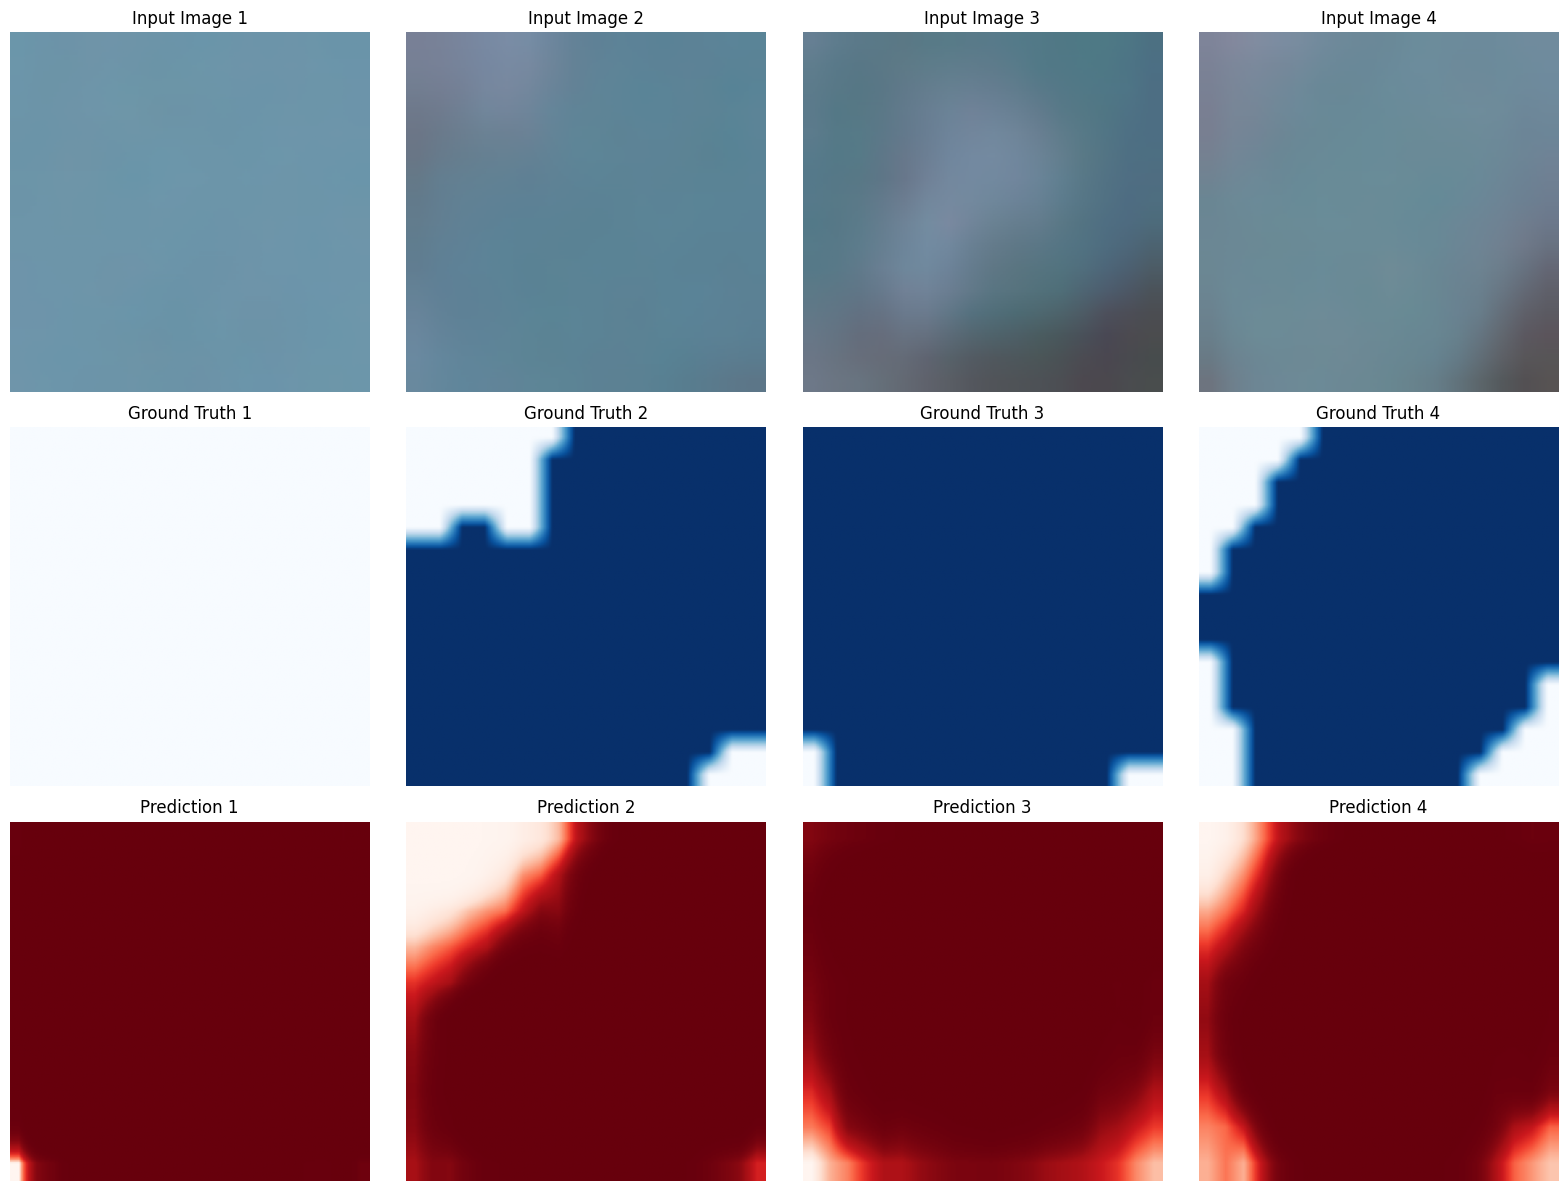


Model Performance:
IoU (Intersection over Union): 0.961
Pixel Accuracy: 0.933


In [13]:
# Test the model on a few examples
model.eval()

# Get a batch of test data
test_images, test_masks = next(iter(boundary_dataloader))
test_images = test_images.to(device)

# Generate predictions
with torch.no_grad():
    predicted_masks = model(test_images)

# Move to CPU for visualization
test_images = test_images.cpu()
test_masks = test_masks.cpu()
predicted_masks = predicted_masks.cpu()

# Visualize results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(min(4, len(test_images))):
    # Original image (denormalize for display)
    img = test_images[i].permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)

    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Input Image {i+1}')
    axes[0, i].axis('off')

    # Ground truth mask
    axes[1, i].imshow(test_masks[i].squeeze(), cmap='Blues')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    axes[1, i].axis('off')

    # Predicted mask
    pred_mask = predicted_masks[i].squeeze()
    axes[2, i].imshow(pred_mask, cmap='Reds')
    axes[2, i].set_title(f'Prediction {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy metrics
def calculate_metrics(pred_masks, true_masks, threshold=0.5):
    pred_binary = (pred_masks > threshold).float()

    intersection = (pred_binary * true_masks).sum()
    union = pred_binary.sum() + true_masks.sum() - intersection

    iou = intersection / (union + 1e-8)
    accuracy = ((pred_binary == true_masks).float().mean())

    return iou.item(), accuracy.item()

iou, accuracy = calculate_metrics(predicted_masks, test_masks)
print(f"\nModel Performance:")
print(f"IoU (Intersection over Union): {iou:.3f}")
print(f"Pixel Accuracy: {accuracy:.3f}")

In [15]:
# Debug: Check the actual data before Step 7
print("=== DEBUGGING IMAGE DATA ===")
print(f"image_rgb type: {type(image_rgb)}")
print(f"image_rgb shape: {image_rgb.shape}")
print(f"image_rgb dtype: {image_rgb.dtype}")
print(f"image_rgb min/max: {image_rgb.min()}/{image_rgb.max()}")

print(f"mask_binary type: {type(mask_binary)}")
print(f"mask_binary shape: {mask_binary.shape}")
print(f"mask_binary dtype: {mask_binary.dtype}")
print(f"mask_binary min/max: {mask_binary.min()}/{mask_binary.max()}")

# Check if there are any invalid values
print(f"image_rgb has NaN: {np.isnan(image_rgb).any()}")
print(f"image_rgb has inf: {np.isinf(image_rgb).any()}")

# Show a small sample
print(f"image_rgb sample (top-left 3x3, channel 0): \n{image_rgb[:3, :3, 0]}")

# Test with just one 224x224 patch
test_patch = image_rgb[:224, :224, :3]  # Take only RGB channels
print(f"\nTest patch shape: {test_patch.shape}")
print(f"Test patch min/max: {test_patch.min()}/{test_patch.max()}")

print("=== DEBUG COMPLETE ===\n")

=== DEBUGGING IMAGE DATA ===
image_rgb type: <class 'numpy.ndarray'>
image_rgb shape: (4673, 1362, 3)
image_rgb dtype: uint8
image_rgb min/max: 70/255
mask_binary type: <class 'numpy.ndarray'>
mask_binary shape: (4673, 1362)
mask_binary dtype: float32
mask_binary min/max: 0.0/1.0
image_rgb has NaN: False
image_rgb has inf: False
image_rgb sample (top-left 3x3, channel 0): 
[[140 144 150]
 [139 140 146]
 [137 140 144]]

Test patch shape: (224, 224, 3)
Test patch min/max: 70/255
=== DEBUG COMPLETE ===



## Step 7: Apply to Full Image

Testing single patch prediction...
Test patch shape: (64, 64, 3)
Test mask shape: (64, 64)
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
Prediction successful!
Original patch: (64, 64, 3)
Resized for DINOv3: (224, 224, 3)
DINOv3 output: (224, 224)
Final prediction: (64, 64)


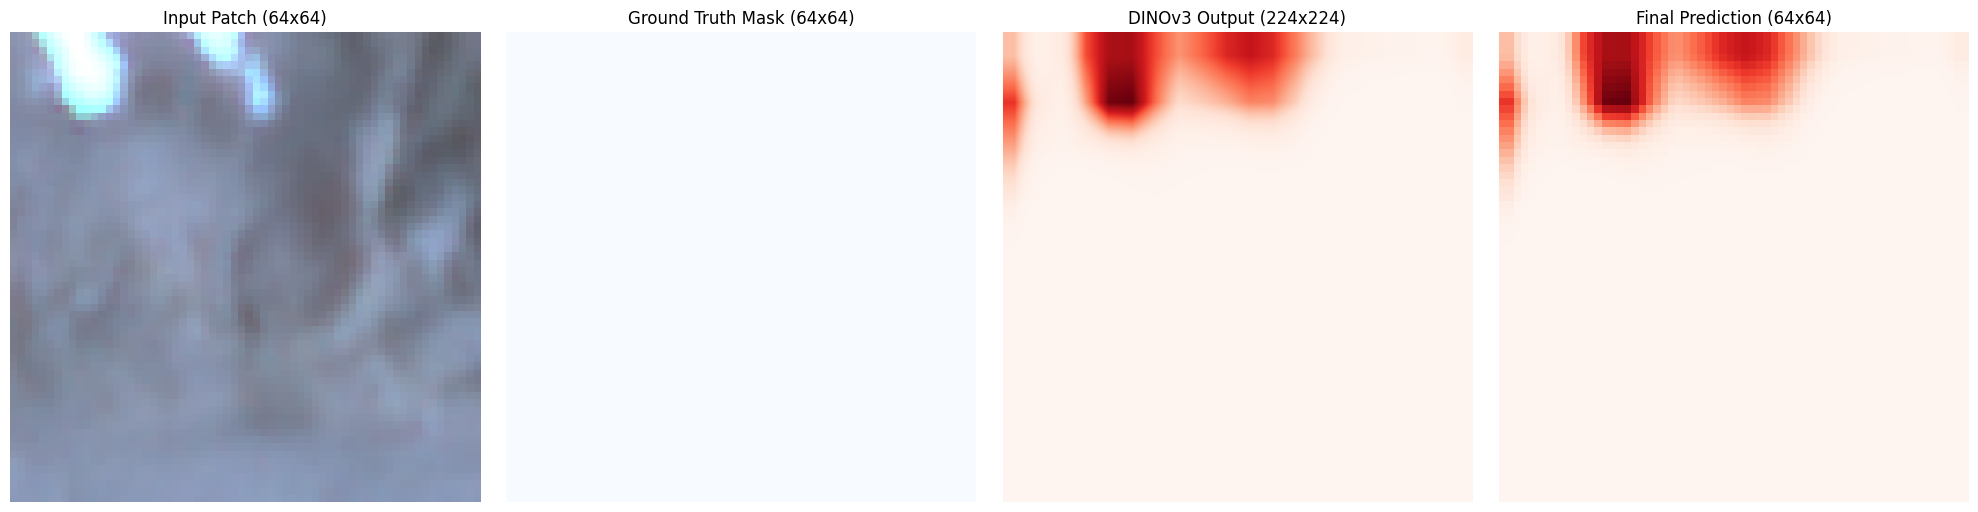


Single Patch Results:
IoU: 0.000
Water pixels detected: 129
Actual water pixels: 0.0

Single patch test completed!


In [16]:
def predict_small_patches_smart(model, image, conceptual_patch_size=16, stride=8):
    """
    Use small conceptual patches, resize to 224 for DINOv3, resize back to small for output
    This way we work with small patches but keep DINOv3 happy with 224x224
    """
    model.eval()
    height, width = image.shape[:2]

    # Create output mask at original resolution
    full_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    patches_processed = 0
    print("Applying model to full image with small patches...")

    with torch.no_grad():
        for y in range(0, height - conceptual_patch_size + 1, stride):
            for x in range(0, width - conceptual_patch_size + 1, stride):
                # Extract small conceptual patch
                small_patch = image[y:y+conceptual_patch_size, x:x+conceptual_patch_size, :3]

                # Resize to 224x224 for DINOv3
                patch_224 = cv2.resize(small_patch, (224, 224))

                # Transform and predict (gets 224x224 output)
                patch_tensor = transform(patch_224).unsqueeze(0).to(device)
                pred_224 = model(patch_tensor).squeeze().cpu().numpy()

                # Resize prediction back to conceptual patch size
                pred_small = cv2.resize(pred_224, (conceptual_patch_size, conceptual_patch_size))

                # Add to full mask
                full_mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size] += pred_small
                count_mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size] += 1

                patches_processed += 1
                if patches_processed % 20 == 0:
                    print(f"  Processed {patches_processed} patches...")

    # Average overlapping predictions
    final_mask = np.divide(full_mask, count_mask, out=np.zeros_like(full_mask), where=count_mask!=0)

    return final_mask

# Test with a simple single patch first
print("Testing single patch prediction...")

# Take a 64x64 patch from the image (small conceptual patch)
test_patch_small = image_rgb[:64, :64, :3]
test_mask_small = mask_binary[:64, :64]

print(f"Test patch shape: {test_patch_small.shape}")
print(f"Test mask shape: {test_mask_small.shape}")

try:
    # Resize to 224x224 for DINOv3
    test_patch_224 = cv2.resize(test_patch_small, (224, 224))

    # Transform for DINOv3
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    patch_tensor = transform(test_patch_224).unsqueeze(0).to(device)

    # Predict (gets 224x224 output)
    with torch.no_grad():
        predicted_224 = model(patch_tensor).squeeze().cpu().numpy()

    # Resize back to 64x64
    predicted_small = cv2.resize(predicted_224, (64, 64))

    print(f"Prediction successful!")
    print(f"Original patch: {test_patch_small.shape}")
    print(f"Resized for DINOv3: {test_patch_224.shape}")
    print(f"DINOv3 output: {predicted_224.shape}")
    print(f"Final prediction: {predicted_small.shape}")

    # Visualize single patch result
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(test_patch_small)
    axes[0].set_title('Input Patch (64x64)')
    axes[0].axis('off')

    axes[1].imshow(test_mask_small, cmap='Blues')
    axes[1].set_title('Ground Truth Mask (64x64)')
    axes[1].axis('off')

    axes[2].imshow(predicted_224, cmap='Reds')
    axes[2].set_title('DINOv3 Output (224x224)')
    axes[2].axis('off')

    axes[3].imshow(predicted_small, cmap='Reds')
    axes[3].set_title('Final Prediction (64x64)')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate simple metrics
    pred_binary = (predicted_small > 0.5).astype(float)
    intersection = (pred_binary * test_mask_small).sum()
    union = pred_binary.sum() + test_mask_small.sum() - intersection
    iou = intersection / (union + 1e-8)

    print(f"\nSingle Patch Results:")
    print(f"IoU: {iou:.3f}")
    print(f"Water pixels detected: {(predicted_small > 0.5).sum()}")
    print(f"Actual water pixels: {test_mask_small.sum()}")

except Exception as e:
    print(f"Error in single patch prediction: {e}")
    import traceback
    traceback.print_exc()

print("\nSingle patch test completed!")

In [26]:

def predict_small_patches_smart_with_boundary(model, image, boundary_mask, conceptual_patch_size=16, stride=8):
    """
    Apply model only to areas inside the boundary mask

    Parameters:
    - model: trained DINOv3 model
    - image: RGB image
    - boundary_mask: binary mask (1=inside boundary, 0=outside)
    - conceptual_patch_size: size of patches to process
    - stride: step size between patches
    """
    model.eval()
    height, width = image.shape[:2]

    # Create output mask at original resolution
    full_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    patches_processed = 0
    patches_skipped = 0
    print("Applying model with boundary constraint...")

    with torch.no_grad():
        for y in range(0, height - conceptual_patch_size + 1, stride):
            for x in range(0, width - conceptual_patch_size + 1, stride):

                # CHECK: Is patch center inside boundary?
                center_y = y + conceptual_patch_size // 2
                center_x = x + conceptual_patch_size // 2

                if boundary_mask[center_y, center_x] == 0:
                    patches_skipped += 1
                    continue  # Skip patches outside boundary

                # Extract small conceptual patch
                small_patch = image[y:y+conceptual_patch_size, x:x+conceptual_patch_size, :3]

                # Resize to 224x224 for DINOv3
                patch_224 = cv2.resize(small_patch, (224, 224))

                # Transform and predict (gets 224x224 output)
                patch_tensor = transform(patch_224).unsqueeze(0).to(device)
                pred_224 = model(patch_tensor).squeeze().cpu().numpy()

                # Resize prediction back to conceptual patch size
                pred_small = cv2.resize(pred_224, (conceptual_patch_size, conceptual_patch_size))

                # Add to full mask
                full_mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size] += pred_small
                count_mask[y:y+conceptual_patch_size, x:x+conceptual_patch_size] += 1

                patches_processed += 1
                if patches_processed % 50 == 0:
                    print(f"  Processed {patches_processed} patches (skipped {patches_skipped})...")

    # Average overlapping predictions
    final_mask = np.divide(full_mask, count_mask, out=np.zeros_like(full_mask), where=count_mask!=0)

    # IMPORTANT: Apply boundary mask to final result
    final_mask = final_mask * boundary_mask

    print(f"Boundary-constrained processing complete!")
    print(f"  Patches processed: {patches_processed}")
    print(f"  Patches skipped (outside boundary): {patches_skipped}")

    return final_mask

# Then use the complete code:
import geopandas as gpd
from rasterio.features import geometry_mask

def create_boundary_mask_from_shapefile(image_path, shapefile_path):
    """
    Create binary boundary mask from shapefile
    """
    # Load shapefile
    shapefile = gpd.read_file(shapefile_path)

    # Load image to get dimensions and CRS
    with rasterio.open(image_path) as src:
        image_crs = src.crs
        image_transform = src.transform
        image_shape = (src.height, src.width)

    # Reproject shapefile if needed
    if shapefile.crs != image_crs:
        shapefile = shapefile.to_crs(image_crs)

    # Create binary mask (1=inside shapes, 0=outside)
    boundary_mask = ~geometry_mask(
        shapefile.geometry,
        transform=image_transform,
        invert=False,
        out_shape=image_shape
    )

    return boundary_mask.astype(np.uint8)

# Usage:
shapefile_path = shp_file  # Make sure shp_file variable is defined
boundary_mask = create_boundary_mask_from_shapefile(image_path, shapefile_path)

print(f"Boundary mask created: {boundary_mask.sum():,} pixels inside boundary ({boundary_mask.sum()/boundary_mask.size*100:.1f}%)")

# Apply model with boundary constraint
predicted_mask = predict_small_patches_smart_with_boundary(
    model, image_rgb, boundary_mask,
    conceptual_patch_size=16,
    stride=8
)


Streaming output truncated to the last 5000 lines.
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial di

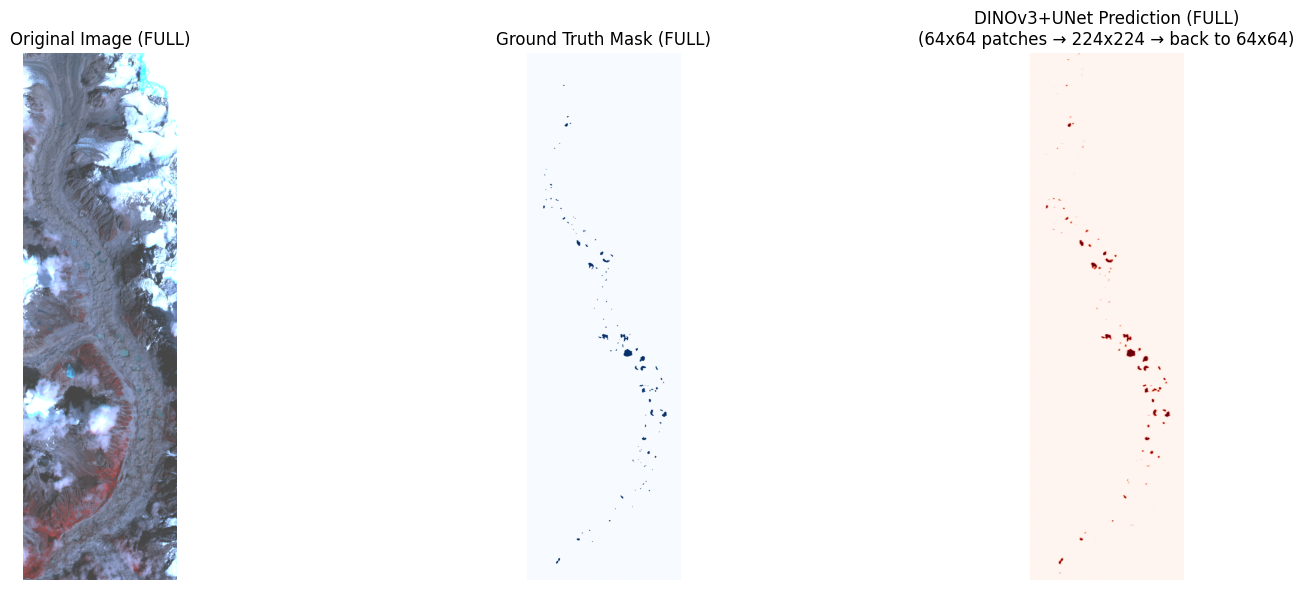


FULL IMAGE Results:
IoU (Intersection over Union): 0.706
Pixel Accuracy: 0.998
True lake pixels: 29678
Predicted lake pixels: 29266

Pixel-level segmentation on FULL IMAGE complete!
✅ Key improvement: Now using 64x64 conceptual patches but keeping DINOv3 happy with 224x224!
✅ This gives you precise lake boundaries at the right scale for individual lakes.


In [27]:

# Visualize full prediction
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_rgb)
axes[0].set_title('Original Image (FULL)')
axes[0].axis('off')

axes[1].imshow(mask_binary, cmap='Blues')
axes[1].set_title('Ground Truth Mask (FULL)')
axes[1].axis('off')

axes[2].imshow(predicted_mask, cmap='Reds')
axes[2].set_title('DINOv3+UNet Prediction (FULL)\n(64x64 patches → 224x224 → back to 64x64)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics for the FULL IMAGE
pred_binary = (predicted_mask > 0.5).astype(float)
true_binary = (mask_binary > 0).astype(float)

intersection = (pred_binary * true_binary).sum()
union = pred_binary.sum() + true_binary.sum() - intersection
iou = intersection / (union + 1e-8)

accuracy = ((pred_binary == true_binary).sum()) / (pred_binary.size)

print(f"\nFULL IMAGE Results:")
print(f"IoU (Intersection over Union): {iou:.3f}")
print(f"Pixel Accuracy: {accuracy:.3f}")
print(f"True lake pixels: {true_binary.sum():.0f}")
print(f"Predicted lake pixels: {pred_binary.sum():.0f}")

print("\nPixel-level segmentation on FULL IMAGE complete!")
print("✅ Key improvement: Now using 64x64 conceptual patches but keeping DINOv3 happy with 224x224!")
print("✅ This gives you precise lake boundaries at the right scale for individual lakes.")

In [29]:
"""
# Apply to FULL IMAGE with small patches
print(f"Processing FULL IMAGE ({image_rgb.shape[0]}x{image_rgb.shape[1]}) with small patches...")

# Predict on ENTIRE image using small patches
predicted_full_mask = predict_small_patches_smart(
    model, image_rgb,  # Use full image instead of subset
    conceptual_patch_size=16,  # Small patches!
    stride=8  # 50% overlap
)

# Visualize full prediction
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_rgb)
axes[0].set_title('Original Image (FULL)')
axes[0].axis('off')

axes[1].imshow(mask_binary, cmap='Blues')
axes[1].set_title('Ground Truth Mask (FULL)')
axes[1].axis('off')

axes[2].imshow(predicted_full_mask, cmap='Reds')
axes[2].set_title('DINOv3+UNet Prediction (FULL)\n(64x64 patches → 224x224 → back to 64x64)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics for the FULL IMAGE
pred_binary = (predicted_full_mask > 0.5).astype(float)
true_binary = (mask_binary > 0).astype(float)

intersection = (pred_binary * true_binary).sum()
union = pred_binary.sum() + true_binary.sum() - intersection
iou = intersection / (union + 1e-8)

accuracy = ((pred_binary == true_binary).sum()) / (pred_binary.size)

print(f"\nFULL IMAGE Results:")
print(f"IoU (Intersection over Union): {iou:.3f}")
print(f"Pixel Accuracy: {accuracy:.3f}")
print(f"True lake pixels: {true_binary.sum():.0f}")
print(f"Predicted lake pixels: {pred_binary.sum():.0f}")

print("\nPixel-level segmentation on FULL IMAGE complete!")
print("✅ Key improvement: Now using 64x64 conceptual patches but keeping DINOv3 happy with 224x224!")
print("✅ This gives you precise lake boundaries at the right scale for individual lakes.")
"""

'\n# Apply to FULL IMAGE with small patches\nprint(f"Processing FULL IMAGE ({image_rgb.shape[0]}x{image_rgb.shape[1]}) with small patches...")\n\n# Predict on ENTIRE image using small patches\npredicted_full_mask = predict_small_patches_smart(\n    model, image_rgb,  # Use full image instead of subset\n    conceptual_patch_size=16,  # Small patches!\n    stride=8  # 50% overlap\n)\n\n# Visualize full prediction\nfig, axes = plt.subplots(1, 3, figsize=(18, 6))\n\naxes[0].imshow(image_rgb)\naxes[0].set_title(\'Original Image (FULL)\')\naxes[0].axis(\'off\')\n\naxes[1].imshow(mask_binary, cmap=\'Blues\')\naxes[1].set_title(\'Ground Truth Mask (FULL)\')\naxes[1].axis(\'off\')\n\naxes[2].imshow(predicted_full_mask, cmap=\'Reds\')\naxes[2].set_title(\'DINOv3+UNet Prediction (FULL)\n(64x64 patches → 224x224 → back to 64x64)\')\naxes[2].axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n\n# Calculate metrics for the FULL IMAGE\npred_binary = (predicted_full_mask > 0.5).astype(float)\ntrue_binary

In [ ]:

# clean prediction from noise on the 16x16 patches with 8 stride
'''
from scipy import ndimage
from skimage.morphology import remove_small_objects, binary_opening, disk

def clean_prediction_mask(predicted_mask, threshold=0.5, min_lake_size=50):
    """
    Clean up noisy predictions while preserving real lakes
    """
    # Convert to binary
    binary_mask = predicted_mask > threshold

    # Remove small isolated pixels (noise)
    cleaned = remove_small_objects(binary_mask, min_size=min_lake_size)

    # Smooth boundaries slightly
    cleaned = binary_opening(cleaned, disk(1))

    return cleaned.astype(float)

# Apply cleaning to your 16x16 result
cleaned_mask = clean_prediction_mask(predicted_mask_16x16, min_lake_size=50)
'''

In [31]:
# # Step 8: Save the Predicted Mask

# import rasterio

# # Define output path
# output_mask_path = '/content/drive/MyDrive/superlakes/predicted_lake_mask_2021-09-04_patch16_stride8_glacier_cut.tif' # You can change this path

# # Get metadata from original image
# with rasterio.open(image_path) as src:
#     meta = src.meta

# # Update metadata for the output mask
# meta.update(
#     dtype=rasterio.float32,  # Save as float32 (or choose appropriate dtype)
#     count=1,               # Single band for the mask
#     nodata=0               # Optional: set nodata value if needed
# )

# # Write the predicted mask to GeoTIFF
# with rasterio.open(output_mask_path, 'w', **meta) as dst:
#     # Need to write the mask data. If subset was used, we need to handle that.
#     # Assuming predicted_full_mask is the subset prediction, we'll save that.
#     # If you want to save the prediction for the *entire* image,
#     # you'd need to run predict_small_patches_smart on the full image first.
#     if 'image_subset' in locals() and 'predicted_mask' in locals():
#         # Assuming predicted_full_mask corresponds to image_subset
#         dst.write(predicted_mask, 1) # Write the first band
#         print(f"✅ Saved predicted mask subset to {output_mask_path}")
#     else:
#         print("Predicted mask for the full image is not available. Please run the prediction on the full image first if needed.")



# Step 8: Save the Predicted Mask

import rasterio

# Define output path
output_mask_path = '/content/drive/MyDrive/superlakes/predicted_lake_mask_2021-09-04_patch16_stride8_glacier_boundary.tif'

# Get metadata from original image
with rasterio.open(image_path) as src:
    meta = src.meta.copy()

# Update metadata for the output mask
meta.update(
    dtype=rasterio.float32,  # Save as float32
    count=1,                # Single band for the mask
    nodata=0                # Set nodata value
)

# Write the predicted mask to GeoTIFF
with rasterio.open(output_mask_path, 'w', **meta) as dst:
    # Save the boundary-constrained prediction
    if 'predicted_mask' in locals():
        dst.write(predicted_mask.astype('float32'), 1)
        print(f"✅ Saved predicted mask to {output_mask_path}")
        print(f"   Mask shape: {predicted_mask.shape}")
        print(f"   Water pixels: {(predicted_mask > 0.5).sum():,}")
        print(f"   Coverage: {(predicted_mask > 0.5).sum() / predicted_mask.size * 100:.2f}%")
    else:
        print("❌ predicted_mask variable not found!")
        print("Available variables:")
        # Check what prediction variables exist
        prediction_vars = [var for var in locals().keys() if 'predict' in var.lower() or 'mask' in var.lower()]
        for var in prediction_vars:
            print(f"  - {var}")


✅ Saved predicted mask to /content/drive/MyDrive/superlakes/predicted_lake_mask_2021-09-04_patch16_stride8_glacier_boundary.tif
   Mask shape: (4673, 1362)
   Water pixels: 29,266
   Coverage: 0.46%


## Summary

**What this notebook achieved:**

1. **True pixel-level segmentation** - each pixel gets classified as lake/not lake
2. **DINOv3 features** - powerful satellite-trained representations
3. **U-Net decoder** - specialized for precise boundary detection
4. **Training on your data** - learns from your manual lake masks

**Key advantages over patch classification:**
- Precise lake boundaries (not rectangular patches)
- Pixel-level accuracy
- Better for tracking lake changes over time
- Scalable to any image size

**Next steps:**
- Train on more data for better accuracy
- Apply to multiple time periods to track changes
- Fine-tune hyperparameters
- Use larger DINOv3 models for better features

Generating full image prediction...
Using 800x800 subset for visualization
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200, 768])
Using spatial dimensions: 10x20 = 200 patches (target: 200)
Final feature map shape: torch.Size([1, 768, 10, 20])
Decoder input shape: torch.Size([1, 768, 10, 20])
Before final resize: torch.Size([1, 1, 10, 20])
After final resize: torch.Size([1, 1, 224, 224])
Final output mask shape: torch.Size([1, 1, 224, 224])
DINOv3 features shape: torch.Size([1, 201, 768])
After removing CLS token: torch.Size([1, 200

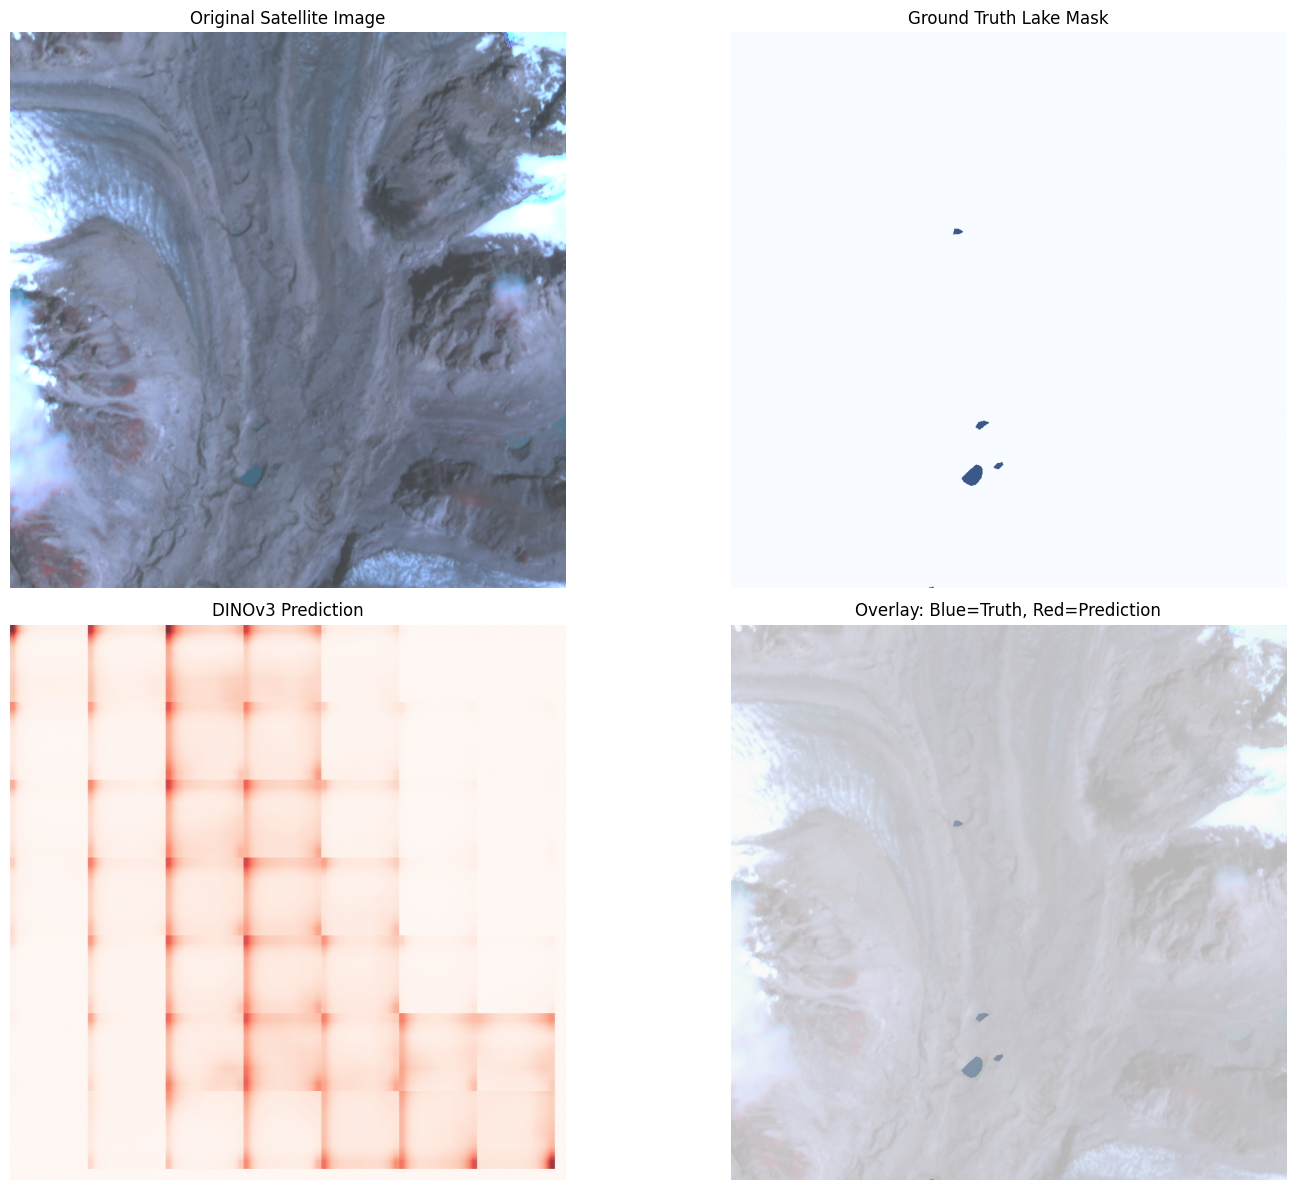


Full Image Results:
IoU (Intersection over Union): 0.000
Pixel Accuracy: 0.999
True lake pixels: 904
Predicted lake pixels: 0


In [21]:
def visualize_final_prediction(model, image, mask, patch_size=65, stride=20, max_size=800):
  """
  Visualize the final full-image prediction vs ground truth
  """
  print("Generating full image prediction...")

  # Use subset if image is too large
  height, width = image.shape[:2]
  if height > max_size or width > max_size:
      h_crop = min(height, max_size)
      w_crop = min(width, max_size)
      image_crop = image[:h_crop, :w_crop]
      mask_crop = mask[:h_crop, :w_crop]
      print(f"Using {h_crop}x{w_crop} subset for visualization")
  else:
      image_crop = image
      mask_crop = mask

  # Generate prediction using sliding window
  model.eval()
  height, width = image_crop.shape[:2]

  full_mask = np.zeros((height, width), dtype=np.float32)
  count_mask = np.zeros((height, width), dtype=np.float32)

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  patches_processed = 0
  with torch.no_grad():
      for y in range(0, height - patch_size + 1, stride):
          for x in range(0, width - patch_size + 1, stride):
              # Extract patch (only RGB channels)
              patch = image_crop[y:y+patch_size, x:x+patch_size, :3]

              # Predict
              patch_tensor = transform(patch).unsqueeze(0).to(device)
              pred_mask = model(patch_tensor).squeeze().cpu().numpy()

              # Add to full mask
              full_mask[y:y+patch_size, x:x+patch_size] += pred_mask
              count_mask[y:y+patch_size, x:x+patch_size] += 1

              patches_processed += 1

  # Average overlapping predictions
  predicted_mask = np.divide(full_mask, count_mask, out=np.zeros_like(full_mask), where=count_mask!=0)

  print(f"Processed {patches_processed} patches")

  # Create visualization
  fig, axes = plt.subplots(2, 2, figsize=(16, 12))

  # Original image
  axes[0, 0].imshow(image_crop)
  axes[0, 0].set_title('Original Satellite Image')
  axes[0, 0].axis('off')

  # Ground truth mask
  axes[0, 1].imshow(mask_crop, cmap='Blues', alpha=0.8)
  axes[0, 1].set_title('Ground Truth Lake Mask')
  axes[0, 1].axis('off')

  # DINOv3 prediction
  axes[1, 0].imshow(predicted_mask, cmap='Reds', alpha=0.8)
  axes[1, 0].set_title('DINOv3 Prediction')
  axes[1, 0].axis('off')

  # Overlay comparison
  axes[1, 1].imshow(image_crop)
  axes[1, 1].imshow(mask_crop, cmap='Blues', alpha=0.4, label='Ground Truth')
  axes[1, 1].imshow(predicted_mask > 0.5, cmap='Reds', alpha=0.4, label='Prediction')
  axes[1, 1].set_title('Overlay: Blue=Truth, Red=Prediction')
  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()

  # Calculate metrics
  pred_binary = (predicted_mask > 0.5).astype(float)
  true_binary = (mask_crop > 0).astype(float)

  intersection = (pred_binary * true_binary).sum()
  union = pred_binary.sum() + true_binary.sum() - intersection
  iou = intersection / (union + 1e-8)

  accuracy = ((pred_binary == true_binary).sum()) / (pred_binary.size)

  print(f"\nFull Image Results:")
  print(f"IoU (Intersection over Union): {iou:.3f}")
  print(f"Pixel Accuracy: {accuracy:.3f}")
  print(f"True lake pixels: {true_binary.sum():.0f}")
  print(f"Predicted lake pixels: {pred_binary.sum():.0f}")

  return predicted_mask

# Generate and visualize final prediction
final_prediction = visualize_final_prediction(model, image_rgb, mask_binary, patch_size=224, stride=112)

# save model

In [36]:
# Save COMPLETE model for easy inference
print("💾 Saving complete model for easy inference...")

# Create save directory
save_dir = '/content/drive/MyDrive/superlakes_dino/models/'
os.makedirs(save_dir, exist_ok=True)

# Save EVERYTHING in one file
complete_model_path = os.path.join(save_dir, 'dinov3_lake_detection_complete.pth')

torch.save({
    'complete_model': model,           # The entire trained model
    'patch_size': 16,                 # Training parameters
    'stride': 8,
    'shapefile_path': shp_file,       # Boundary constraint used
    'training_info': {
        'epochs': 5,
        'dataset_size': len(boundary_dataset),
        'boundary_pixels': boundary_mask.sum(),
        'image_shape': image_rgb.shape
    }
}, complete_model_path)

print(f"✅ Complete model saved to: {complete_model_path}")
print("🎉 Ready for simple inference!")


💾 Saving complete model for easy inference...
✅ Complete model saved to: /content/drive/MyDrive/superlakes_dino/models/dinov3_lake_detection_complete.pth
🎉 Ready for simple inference!


In [37]:

# Step 1: Save the Model with All Dependencies

# First, add this to your notebook to save everything needed:

# Save complete model package for inference
def save_inference_ready_model():
    """Save model with all code needed for inference"""

    # Save model weights and config
    model_package = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'dinov3_model': 'facebook/dinov3-vitb16-pretrain-lvd1689m',
            'feature_dim': 768,
            'target_size': 224,
            'patch_size': 16,
            'stride': 8
        },
        'boundary_shapefile': shp_file,  # Save path to boundary shapefile
        'training_info': {
            'epochs': 5,
            'performance': {
                'iou': iou if 'iou' in locals() else None,
                'accuracy': accuracy if 'accuracy' in locals() else None
            }
        }
    }

    model_path = '/content/drive/MyDrive/superlakes_dino/models/dinov3_lake_detection_complete.pth.pth'
    torch.save(model_package, model_path)

    print(f"✅ Inference-ready model saved to: {model_path}")
    return model_path

# Save the complete package
model_path = save_inference_ready_model()


✅ Inference-ready model saved to: /content/drive/MyDrive/superlakes_dino/models/dinov3_lake_inference_ready.pth
